In [33]:
# for now, lets add ../src to sys.path
import sys
sys.path.append('../src')

# import basic stuff
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import zscore

# import the arviz package
import arviz as az

# import CmdStanPy
from cmdstanpy import cmdstan_path, CmdStanModel

# import SSM
import ssm
from ssm.observations import InputDrivenObservations

# import plotnine for plotting
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, stat_summary, geom_errorbar, facet_grid, geom_line, theme, theme_seaborn, theme_538, theme_matplotlib, scale_color_brewer, theme_minimal, theme_light, geom_violin

In [63]:
mouse_nickname = "CSHL_015" # nickname of the mouse

# load the data into a dataframe
df = pd.read_csv("../data/preprocessed-trials.csv", na_values="NA")

# filter for nickname
df = df[df["subject_nickname"] == mouse_nickname] #CSHL_015 KS019

df["stim_contrast_minus_1"] = np.sign(df["stim_contrast"].shift(1).fillna(0))
df["response_cw_minus_1"] = df["response_cw"].shift(1).fillna(0).astype(int)
df["intercept"] = 1


T = [len(d) for _,d in df.groupby("session_start_time")]

df[["stim_contrast", "stim_contrast_minus_1", "response_cw_minus_1"]] = df[["stim_contrast", "stim_contrast_minus_1", "response_cw_minus_1"]].apply(zscore)

x = df[["intercept", "stim_contrast", "stim_contrast_minus_1", "response_cw_minus_1"]].values
x_sessions = [d[["intercept", "stim_contrast", "stim_contrast_minus_1", "response_cw_minus_1"]].values for _,d in df.groupby("session_start_time")]

u = df[["trial_id"]].values

y = 1-df["response_cw"].values.astype(int)
y_sessions = [d[["response_cw"]].values.astype(int).reshape(-1, 1) for _,d in df.groupby("session_start_time")]

/Users/marcpabst/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (13,24,29) have mixed types.Specify dtype option on import or set low_memory=False.


In [35]:
# write data to csv (for diagnostics in R)
df[["session_start_time", "intercept", "stim_contrast", "stim_contrast_minus_1", "response_cw_minus_1", "response_cw"]].to_csv("../data/diag.csv")

In [64]:
ssm_model  = ssm.HMM(3, 1, 4, 
                observations=InputDrivenObservations(K=3, D=1, M=4, prior_mean = 0, prior_sigma = 5), 
                transitions="sticky", transition_kwargs=dict(alpha=np.array([1,1,3]), kappa=0))
_ = ssm_model.fit(y_sessions, inputs=x_sessions,
                method="em", num_iters=1000, tolerance=10**-4)

Converged to LP: -2975.5:   5%|▌         | 54/1000 [00:03<00:57, 16.45it/s]


In [65]:
init_betas_x = ssm_model.observations.params
init_baseA = np.exp(ssm_model.transitions.params)

In [66]:
# load the model code and compile it
stan_model = CmdStanModel(stan_file = "../stan-models/glm-hmm.stan")


# define the input data for the model
stan_data =  {
    "T": T,             # length of each sequence
    "N": len(T),        # number of sequences
    "I": np.sum(T),     # number of (flattend/total) obervations
    "M": 4,             # number of predictors for observations
    "K": 3,             # number of hidden states
    "R": 1,             # dimensionality of observations
    "x": x,             # predictors for obervation model
    "y": np.squeeze(y)  # observations
  }

# fit the model(=sample from the posterior)
stan_model_fit = stan_model.sample(data=stan_data, chains=1, iter_sampling = 1000, iter_warmup=1000, refresh=5, show_progress="notebook")

# convert to arviz datastructure 
stan_model_fit_az = az.from_cmdstanpy(
    posterior=stan_model_fit,
    observed_data={"y": stan_data["y"]}, 
    save_warmup=False,
    coords = {"State": [0,1, 2], "Coefficient": ["intercept", "stim contrast", "stim contrast minus 1", "response cw minus 1"]},
    dims = {"betas_x": ["State", "Coefficient"]}
)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/marcpabst/Documents/Repositories/bayesian-mice-decisions/stan-models/glm-hmm


Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:numba.core.transforms:finding looplift candidates


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

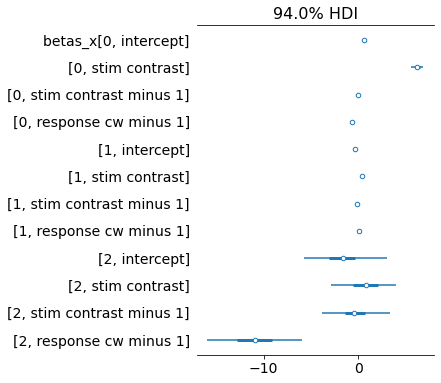

In [67]:
az.plot_forest(stan_model_fit_az, var_names=["betas_x"])

In [68]:
np.set_printoptions(suppress=True)
np.around(init_betas_x,2)

array([[[ 1.  ,  6.  ,  0.02, -0.49]],

       [[-0.06, -0.05, -0.27, -0.79]],

       [[-2.24,  1.49,  0.36, -0.21]]])

In [69]:
np.around(init_baseA,2)

array([[[0.96, 0.01, 0.03],
        [0.02, 0.97, 0.01],
        [0.07, 0.  , 0.93]]])

/Users/marcpabst/miniforge3/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:239: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid


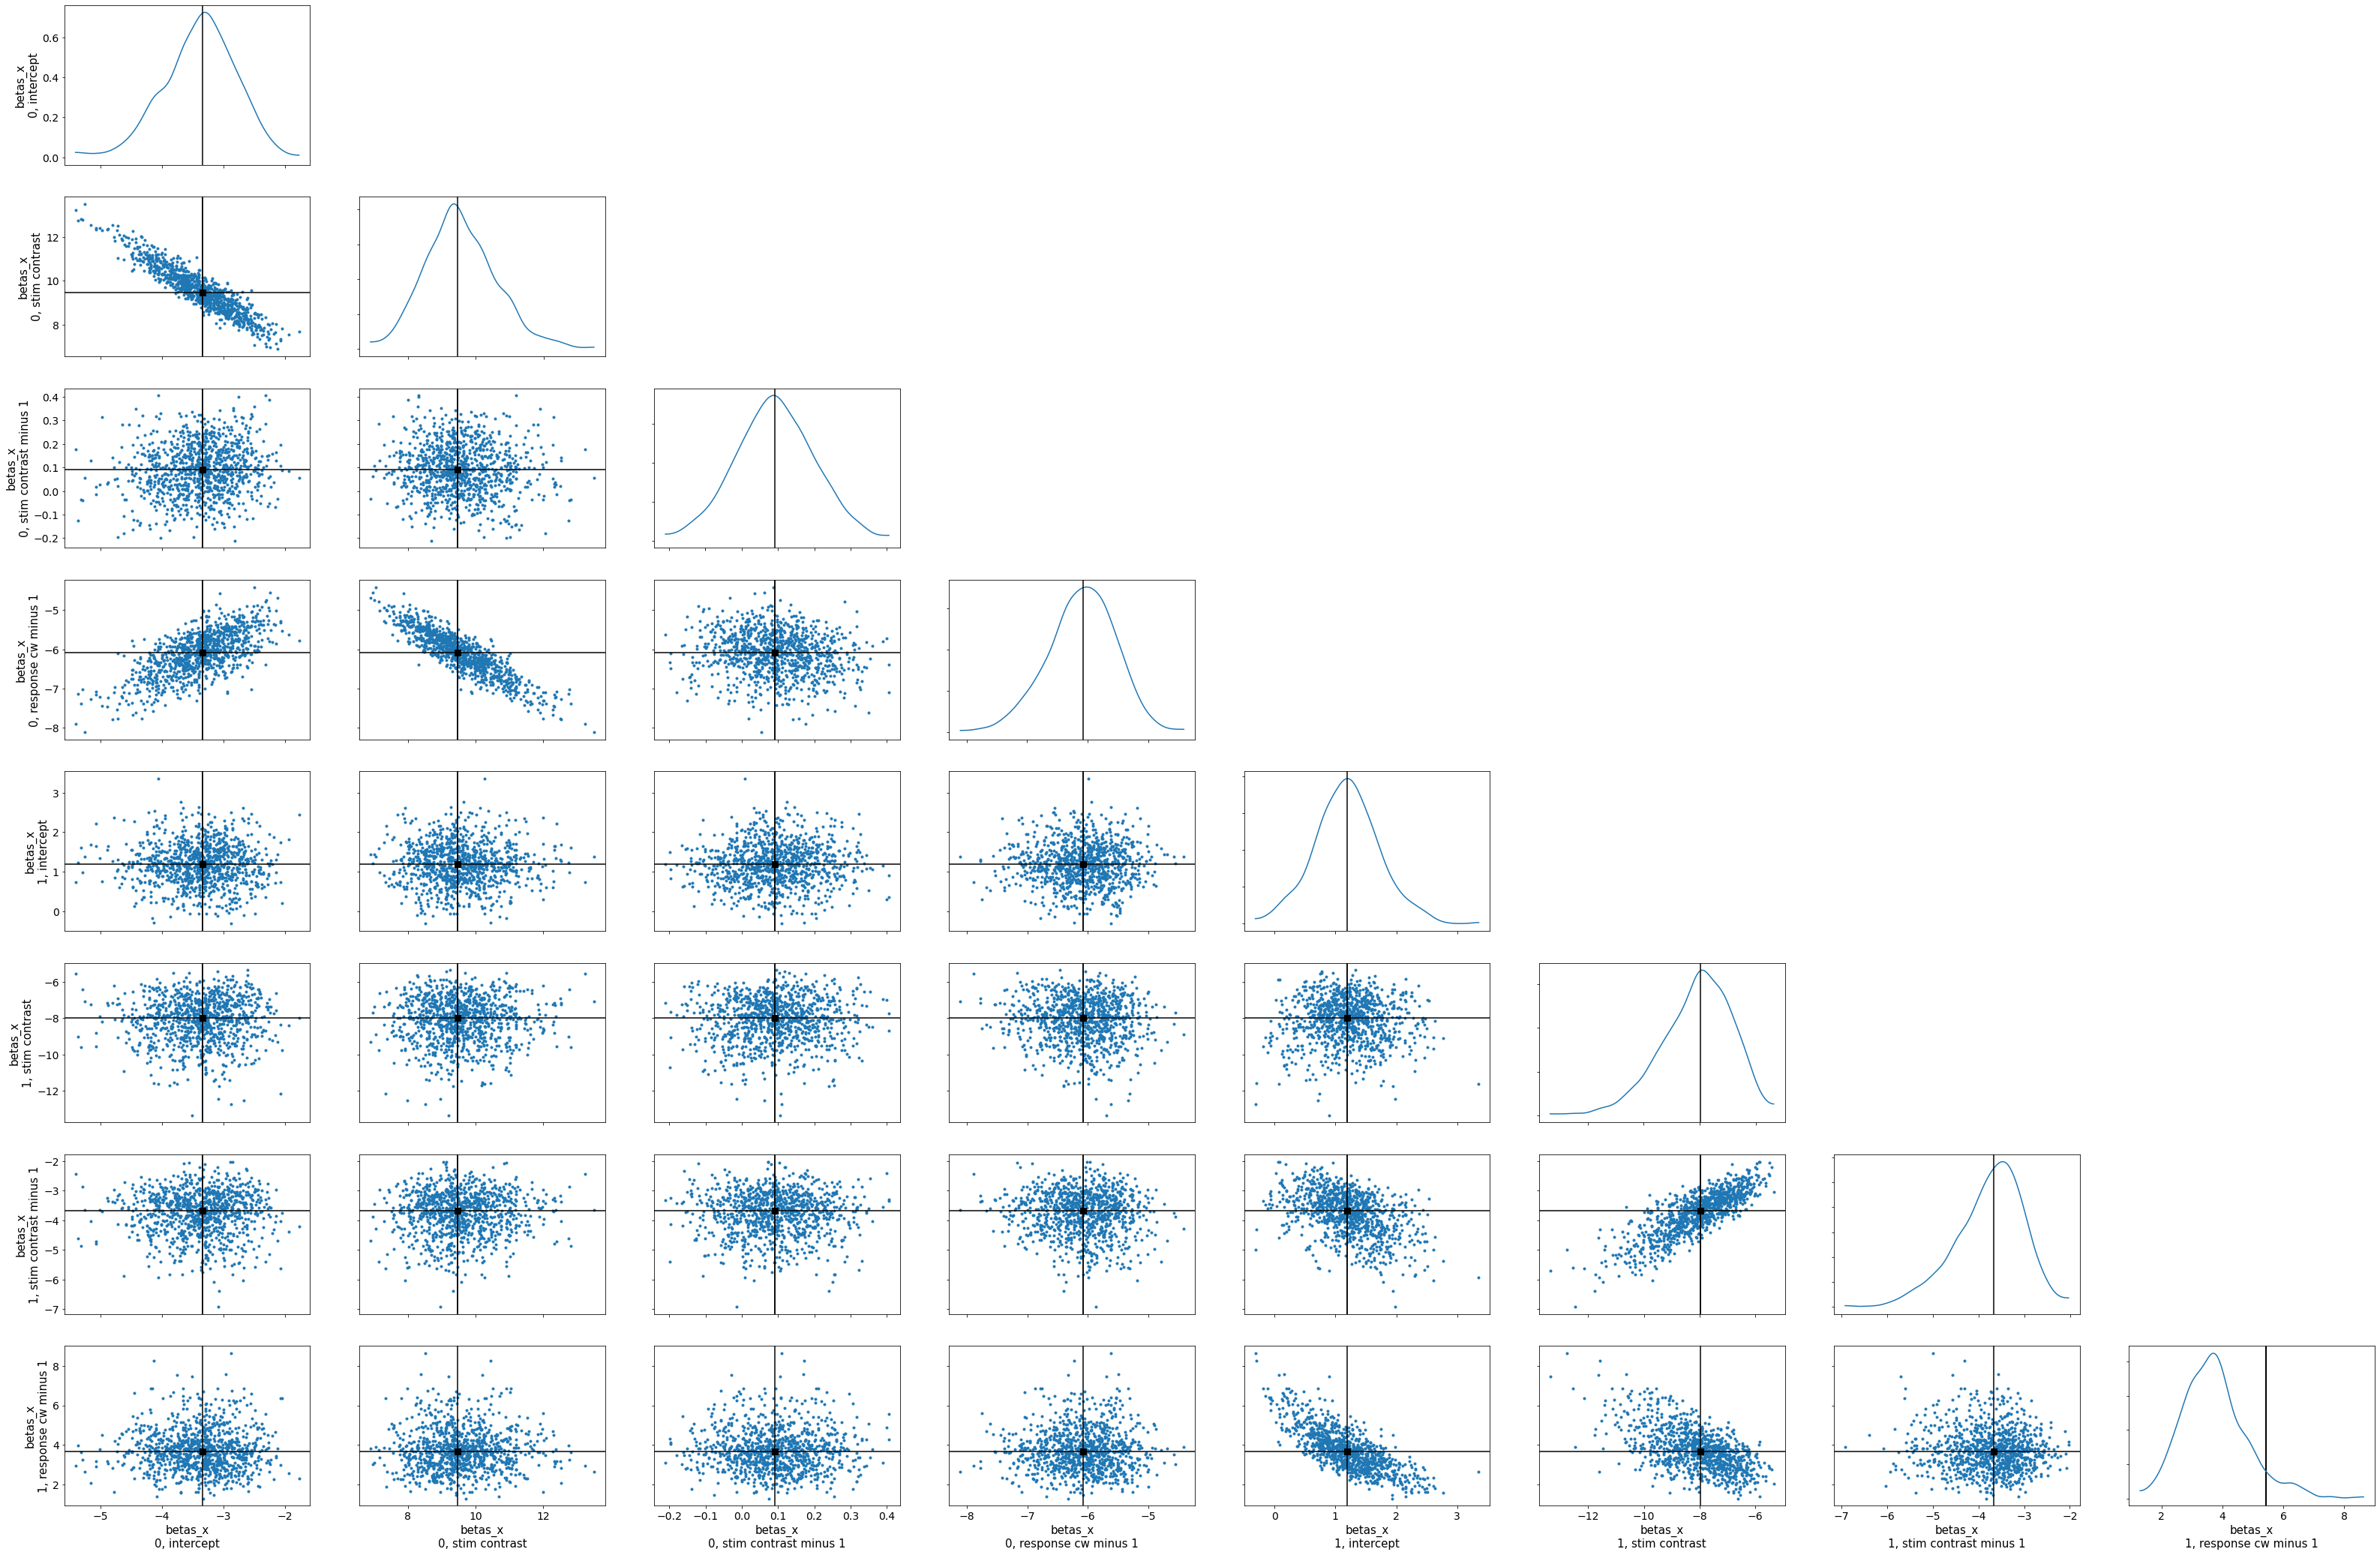

In [21]:
_ = az.plot_pair(stan_model_fit_az, var_names="betas_x", marginals=True, point_estimate="median")

In [ ]:
# for the ssm data ...
# sorry this is a bit of a mess, but it's a lot easier to work with the data in this format
# I also align the states manually, because it's nice for comparison

ssm_df = pd.DataFrame()

for state, state_name in zip([0,1], ["state 1", "state 2"]):
    state_data = ssm_model.observations.params[state]
    for coeff, coeff_name in enumerate(["intercept", "stim contrast", "stim contrast minus 1", "response cw minus 1"]):
        ssm_df = ssm_df.append({"State": state, "Coefficient": coeff_name, "value": state_data[0, coeff]}, ignore_index=True)
ssm_df["Source"] = "SSM"

# ... and for the stan data
draws = stan_model_fit_az.posterior.betas_x.to_dataframe().reset_index()
draws["Source"] = "Stan"

In [ ]:
draws

In [ ]:
def stat_hdi(series):
    data = series.values
    min, max = az.hdi(data, hdi_prob=0.89)
    return pd.DataFrame({"ymin": [min], "ymax": [max]})

(ggplot(draws, aes('Coefficient', 'betas_x', color='factor(State)'))
 + facet_grid('State ~ Source')
 + stat_summary()
 #+ stat_summary(geom = "geom_errorbar", fun_data = stat_hdi)
 + geom_violin(style="left")
 + stat_summary(geom = "geom_line",  group="State")
 # now the same for the ssm data (only points)
 + geom_point(data=ssm_df, mapping=aes("Coefficient", "value"), group="State")
 + geom_line(data=ssm_df, mapping=aes("Coefficient", "value"), group="State")
 + theme_light()
 + scale_color_brewer(type='qual', palette=2)
 + theme(figure_size = (15, 7))
 )

In [ ]:
np.exp(ssm_model.transitions.params)

In [ ]:
stan_model_fit_az.posterior.A.mean(["chain","draw"])

In [ ]:
stan_model_fit2var = stan_model2.variational(data=stan_data)
inits_dict = {k: v for k, v in stan_model_fit2var.variational_params_dict.items() if "betas" in k or "baseP" in k}

In [83]:
# load the model code and compile it
stan_model2 = CmdStanModel(stan_file = "../stan-models/tv-glm-hmm.stan")




# define the input data for the model
stan_data =  {
    "T": T,             # length of each sequence
    "N": len(T),        # number of sequences
    "I": np.sum(T),     # number of (flattend/total) obervations
    "M": 4,             # number of predictors for observations
    "P": 1,             # number of predcitors for transitions
    "K": 2,             # number of hidden states
    "R": 1,             # dimensionality of observations
    "x": x,             # predictors for obervation model
    "u": u,             # predictors for transition model
    "y": np.squeeze(y)  # observations
  }

# fit the model(=sample from the posterior)
stan_model_fit2 = stan_model2.sample(data=stan_data, chains=4, inits=inits_dict, iter_sampling = 5000, iter_warmup=2000, refresh=5, show_progress="notebook")

# convert to arviz datastructure 
stan_model_fit_az2 = az.from_cmdstanpy(
    posterior=stan_model_fit2,
    observed_data={"y": stan_data["y"]}, 
    save_warmup=False,
    coords = {"State": [0,1], "Coefficient_x": ["intercept", "stim contrast", "stim contrast minus 1", "response cw minus 1"], "Coefficient_u": ["intercept"]},
    dims = {"betas_x": ["State", "Coefficient"], "betas_u": ["State", "Coefficient_u"]}
)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/marcpabst/Documents/Repositories/bayesian-mice-decisions/stan-models/tv-glm-hmm


Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

In [86]:
stan_model_fit_az2.posterior.betas_u.values.mean(1)

array([[[-0.0153006 ],
        [ 0.01747843]],

       [[ 0.05142728],
        [ 0.08071794]],

       [[-0.04404567],
        [ 0.06041485]],

       [[ 0.06160463],
        [-0.0033127 ]]])

In [87]:
az.rhat(stan_model_fit_az2)

<xarray.Dataset>
Dimensions:              (pi_dim_0: 2, State: 2, Coefficient: 4, baseP_dim_0: 2, baseP_dim_1: 2, Coefficient_u: 1, logpi_dim_0: 2, log_like_sess_dim_0: 69)
Coordinates:
  * pi_dim_0             (pi_dim_0) int64 0 1
  * State                (State) int64 0 1
  * Coefficient          (Coefficient) int64 0 1 2 3
  * baseP_dim_0          (baseP_dim_0) int64 0 1
  * baseP_dim_1          (baseP_dim_1) int64 0 1
  * Coefficient_u        (Coefficient_u) <U9 'intercept'
  * logpi_dim_0          (logpi_dim_0) int64 0 1
  * log_like_sess_dim_0  (log_like_sess_dim_0) int64 0 1 2 3 4 ... 65 66 67 68
Data variables:
    pi                   (pi_dim_0) float64 1.638 1.638
    betas_x              (State, Coefficient) float64 1.66 1.733 ... 1.218 1.733
    baseP                (baseP_dim_0, baseP_dim_1) float64 1.733 ... 1.022
    betas_u              (State, Coefficient_u) float64 1.0 1.0
    logpi                (logpi_dim_0) float64 1.638 1.638
    log_like_sess        (log_like_sess_dim_0) float64 1.733 1.733 ... 1.669

In [88]:
az.plot_ppc(stan_model_fit_az2 g)

TypeError: `data` argument must have the group "posterior_predictive" for ppcplot